In [2]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""





'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

In [3]:
def calcular_specificity_multiclase(y_true, y_pred):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    specificity_scores = []

    for i in range(len(mcm)):
        tn = mcm[i][0, 0]
        fp = mcm[i][0, 1]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        specificity_scores.append(specificity)

    return specificity_scores, np.nanmean(specificity_scores)


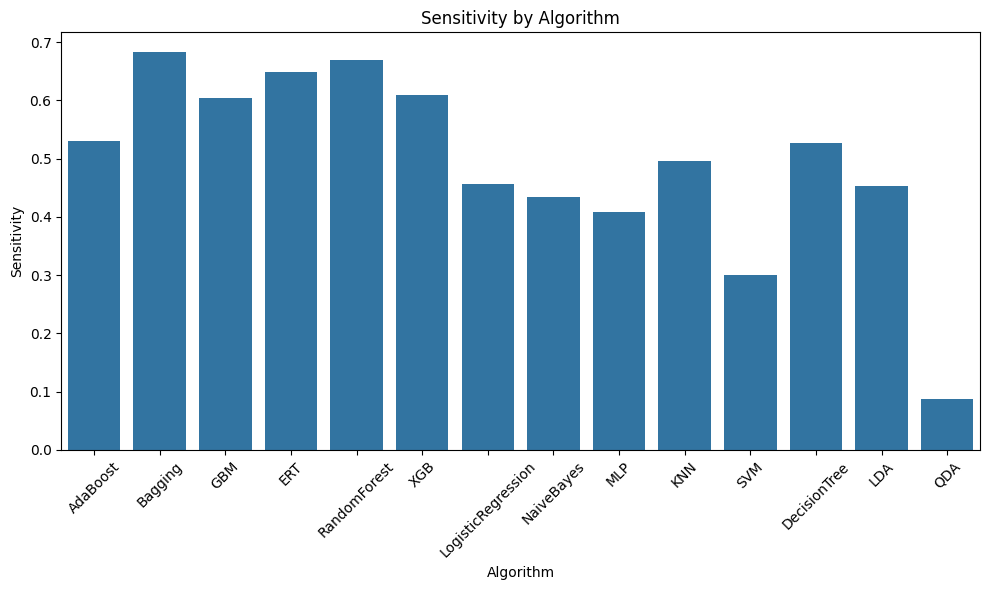

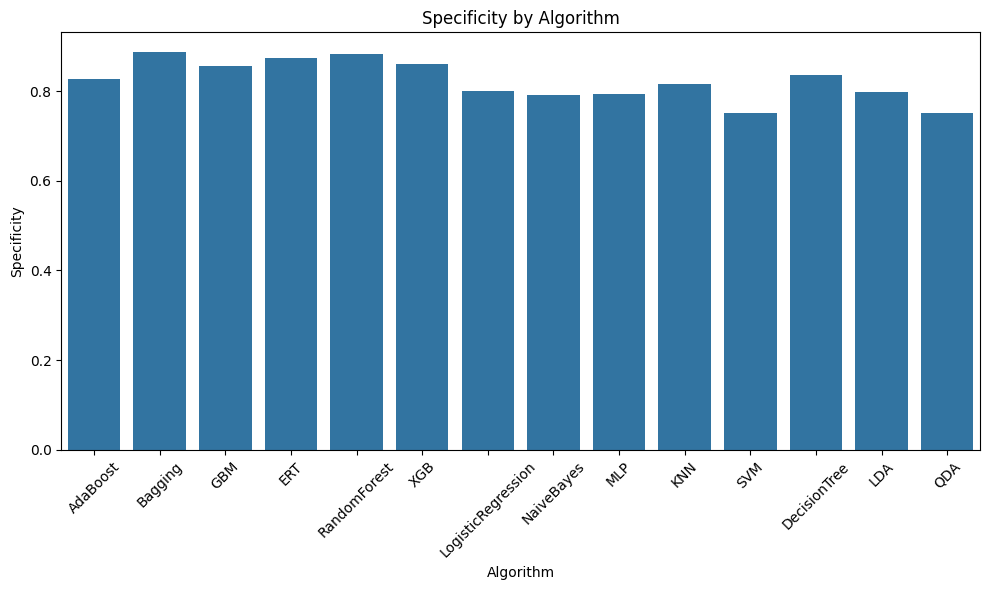

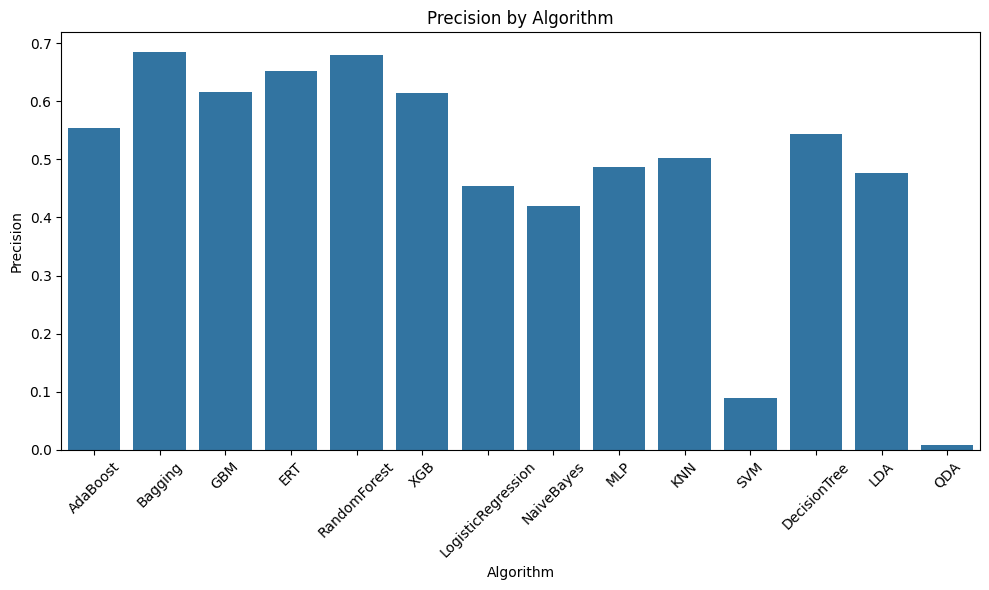

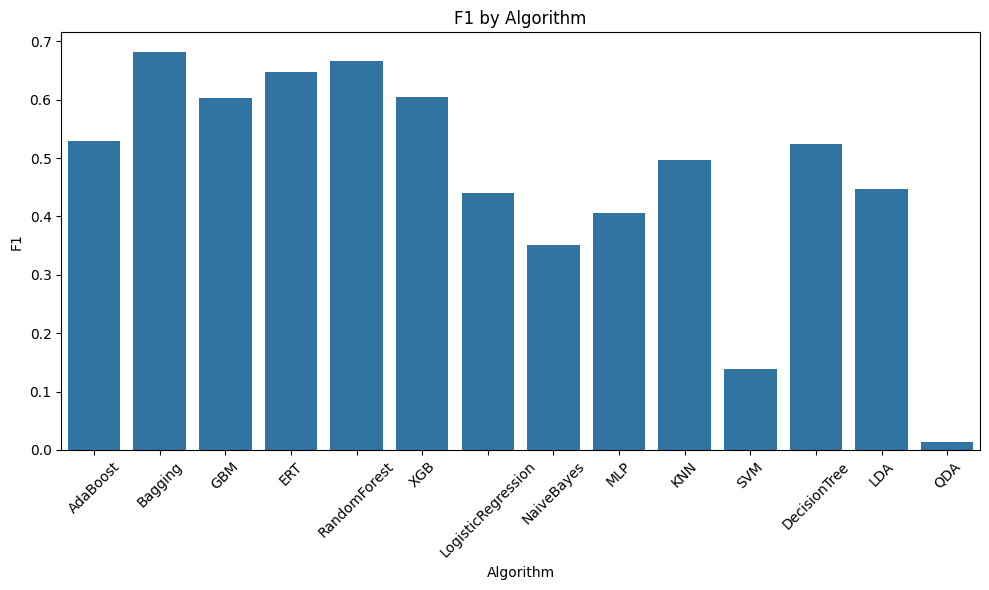

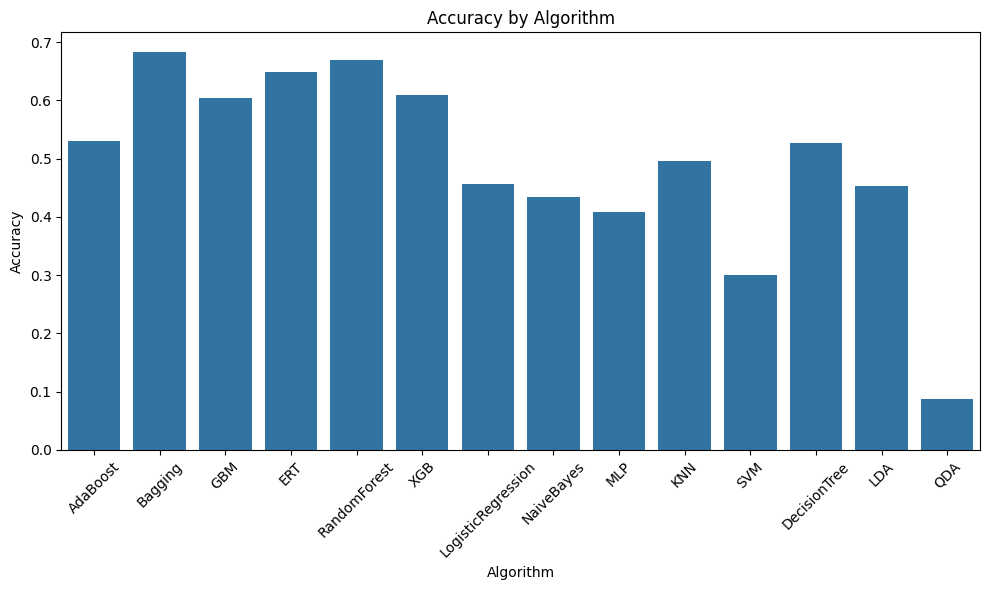

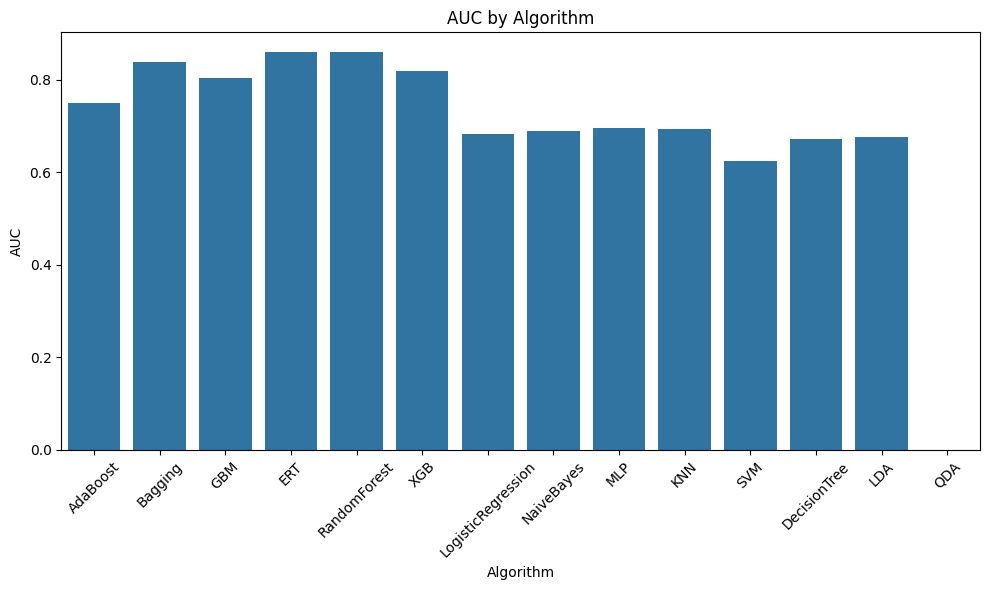

In [4]:
# Paso 2: Carga de datos y preprocesamiento
archivo = "weatherHistory_10.csv"
df = pd.read_csv(archivo)

# Paso 2: Preprocesamiento
# Seleccionar solo las clases más frecuentes
top_classes = df['Summary'].value_counts()[df['Summary'].value_counts() >= 50].index.tolist()
df = df[df['Summary'].isin(top_classes)].copy()

# Codificar variable objetivo
df['target'] = df['Summary'].astype('category').cat.codes

# Eliminar columnas no relevantes
df.drop(['Formatted Date', 'Summary', 'Daily Summary'], axis=1, inplace=True)

# Convertir variables a numéricas
X = df.drop('target', axis=1)
y = df['target']

# Separar en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#Paso 3 convertir target a numerico 

df['target'] = df['target'].astype('category').cat.codes

# One-hot y división
y = df['target']
X = pd.get_dummies(df.drop('target', axis=1), drop_first=True).astype('float64')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Función actualizada para multiclase
def metricas(model, model_label, X_train, X_valid, y_train, y_valid):
    y_pred = model.predict(X_valid)

    # AUC multiclase
    try:
        y_pred_prob = model.predict_proba(X_valid)
        auc = roc_auc_score(y_valid, y_pred_prob, multi_class='ovr', average='weighted')
    except (AttributeError, ValueError):
        auc = np.nan

    cm = confusion_matrix(y_valid, y_pred)
    sensitivity = recall_score(y_valid, y_pred, average='weighted')  # Recall promedio ponderado
    specificity_list, specificity_avg = calcular_specificity_multiclase(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_valid, y_pred, average='weighted')
    accuracy = accuracy_score(y_valid, y_pred)

    return {
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity_avg,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    }

# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

# Entrenar modelos
results = []
X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

for model_label, model in models.items():
    model.fit(X_train_np, y_train)
    result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
    results.append(result)

df_results = pd.DataFrame(results)

# Paso 6: Visualización
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} by Algorithm')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


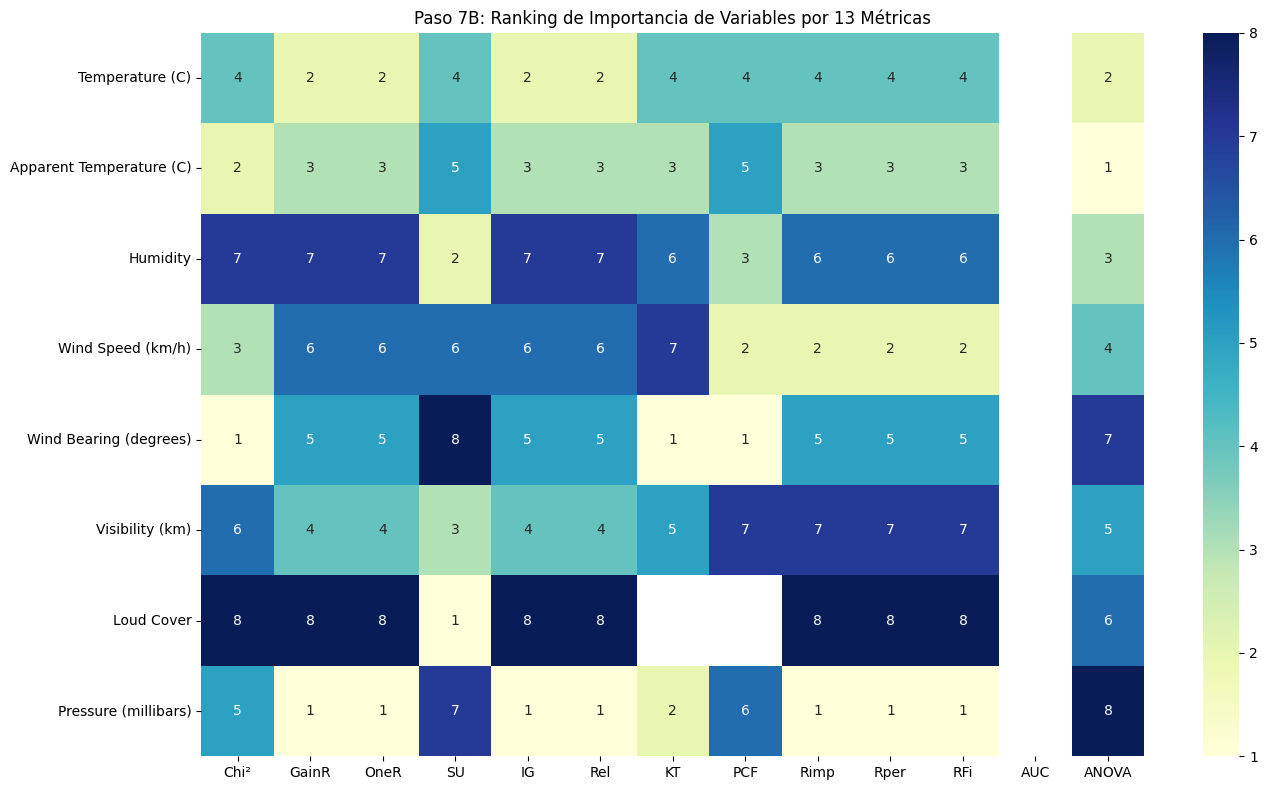

                          Chi²  GainR  OneR   SU   IG  Rel   KT  PCF  Rimp  \
Pressure (millibars)       5.0    1.0   1.0  7.0  1.0  1.0  2.0  6.0   1.0   
Apparent Temperature (C)   2.0    3.0   3.0  5.0  3.0  3.0  3.0  5.0   3.0   
Temperature (C)            4.0    2.0   2.0  4.0  2.0  2.0  4.0  4.0   4.0   
Wind Speed (km/h)          3.0    6.0   6.0  6.0  6.0  6.0  7.0  2.0   2.0   
Wind Bearing (degrees)     1.0    5.0   5.0  8.0  5.0  5.0  1.0  1.0   5.0   
Visibility (km)            6.0    4.0   4.0  3.0  4.0  4.0  5.0  7.0   7.0   
Humidity                   7.0    7.0   7.0  2.0  7.0  7.0  6.0  3.0   6.0   
Loud Cover                 8.0    8.0   8.0  1.0  8.0  8.0  NaN  NaN   8.0   

                          Rper  RFi  AUC  ANOVA      Mean  Rank  
Pressure (millibars)       1.0  1.0  NaN    8.0  2.916667   1.0  
Apparent Temperature (C)   3.0  3.0  NaN    1.0  3.083333   2.0  
Temperature (C)            4.0  4.0  NaN    2.0  3.166667   3.0  
Wind Speed (km/h)          2.0  2

In [5]:
# Paso 7: Importancia de las características

# Preparar datos desde el dataset ya procesado (X, y)
df_importancia = X.copy()
df_importancia['target'] = y

# Asegurar que todos los valores sean positivos para chi2
X_imp = df_importancia.drop('target', axis=1).apply(lambda col: col - col.min() + 1e-6)
y_imp = df_importancia['target']

# Métricas base
chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp)
anova_vals, _ = f_classif(X_imp, y_imp)

# Random Forest Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# AUC por variable multiclase
auc_vals = []
for col in X_imp.columns:
    try:
        auc = roc_auc_score(y_imp, X_imp[col], multi_class='ovr', average='macro')
    except:
        auc = np.nan
    auc_vals.append(auc)

# Kendall Tau
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]

# PCF (punto biserial)
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]

# Aproximaciones para GainR, OneR, SU, Rel, Rimp, Rper
# Utilizamos MI como proxy, SU se normaliza por varianza
gainr_vals = mi_vals
oner_vals = mi_vals
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

# Compilar en DataFrame
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

#Paso 7B: Cálculo de 13 métricas de importancia y ranking final
# Calcular rankings
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Exportar a CSV (puedes personalizar la ruta)
ranking_df.sort_values("Rank").to_csv("ranking_importancia_metricas.csv")

# Visualización
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada por importancia
print(ranking_df.sort_values("Rank"))


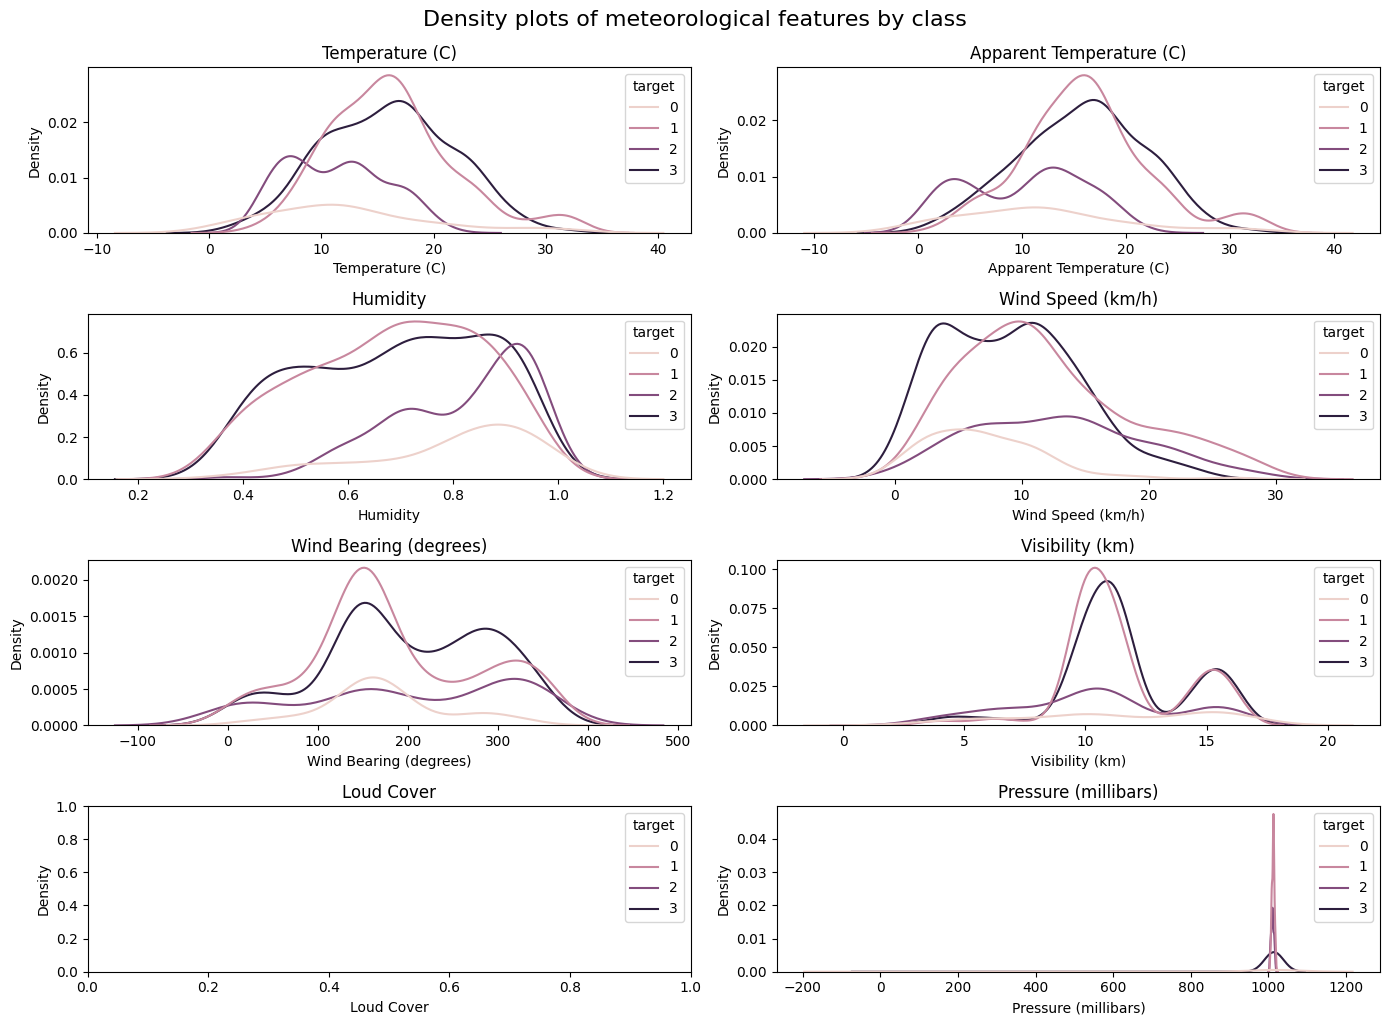

In [6]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase

numerical_features = X.columns.tolist()
df_plot = X.copy()
df_plot['target'] = y

plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot((len(numerical_features) + 1) // 2, 2, i)
    sns.kdeplot(data=df_plot, x=col, hue='target', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Density plots of meteorological features by class", fontsize=16, y=1.02)
plt.show()


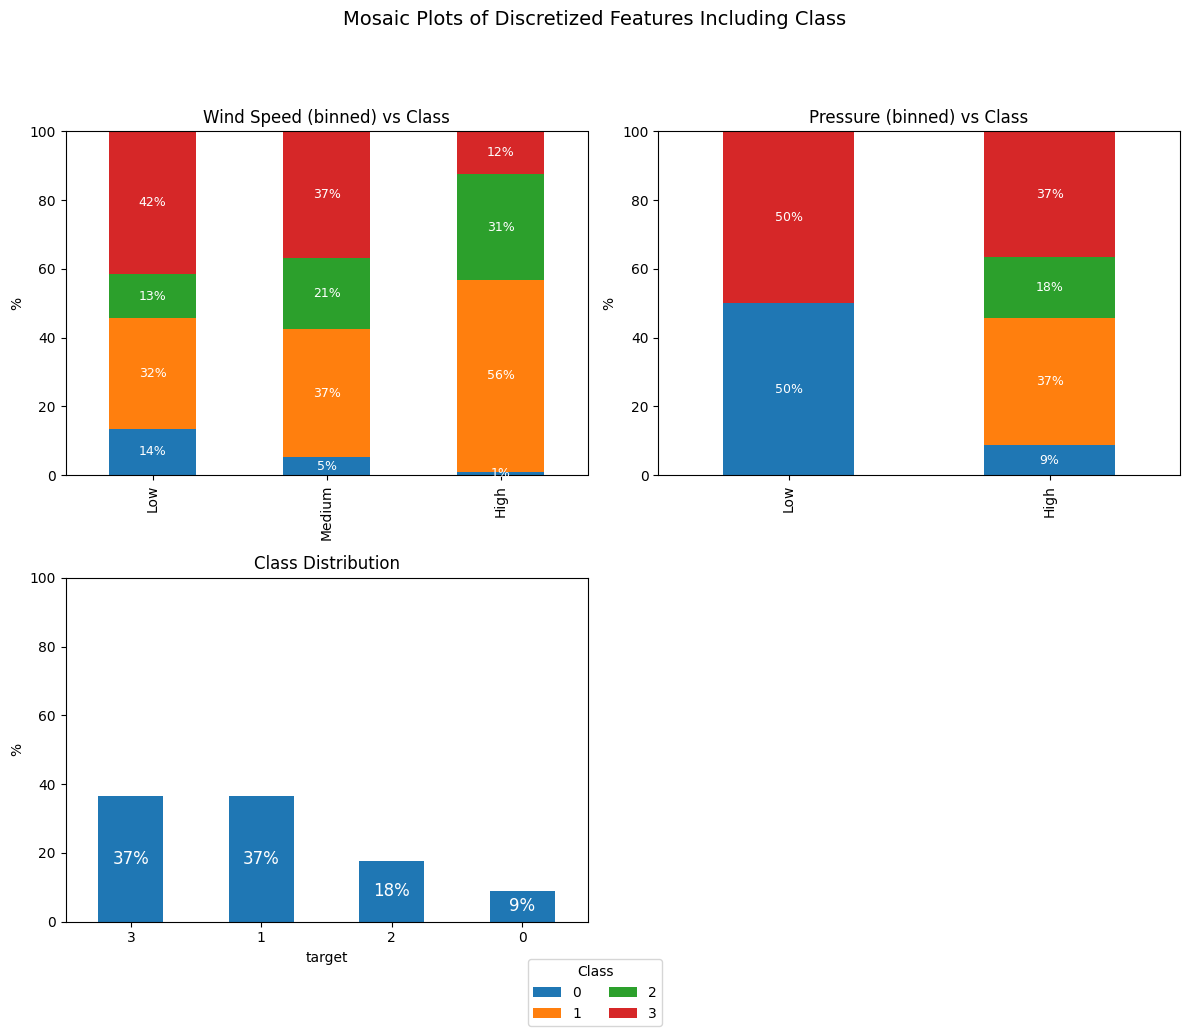

In [7]:
# Paso 7D: Gráficos de mosaico para variables categóricas incluyendo Class

# Crear copia de los datos
mosaic_df = X.copy()
mosaic_df['target'] = y

# Discretizar dos variables continuas para visualización como categóricas
mosaic_df['Wind Speed (binned)'] = pd.cut(mosaic_df['Wind Speed (km/h)'], bins=3, labels=["Low", "Medium", "High"])
mosaic_df['Pressure (binned)'] = pd.cut(mosaic_df['Pressure (millibars)'], bins=3, labels=["Low", "Medium", "High"])

categorical_cols = ['Wind Speed (binned)', 'Pressure (binned)', 'target']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(mosaic_df[col], mosaic_df['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='white', fontsize=9)
        ax.set_title(f"{col} vs Class")
        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
    else:
        class_counts = mosaic_df['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', ax=ax)
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='white', fontsize=12)
        ax.set_title("Class Distribution")
        ax.set_ylabel('%')
        ax.set_xticklabels(class_counts.index, rotation=0)
        ax.set_ylim(0, 100)

# Eliminar subplots sobrantes si hay menos de 4 gráficos
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Class", loc='lower center', ncol=2)
plt.suptitle('Mosaic Plots of Discretized Features Including Class', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()



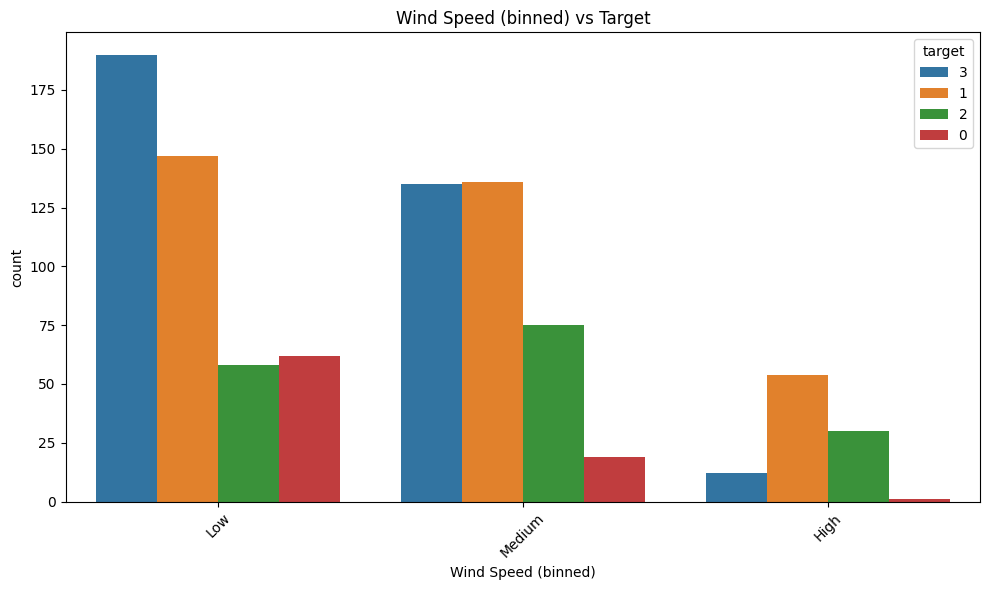

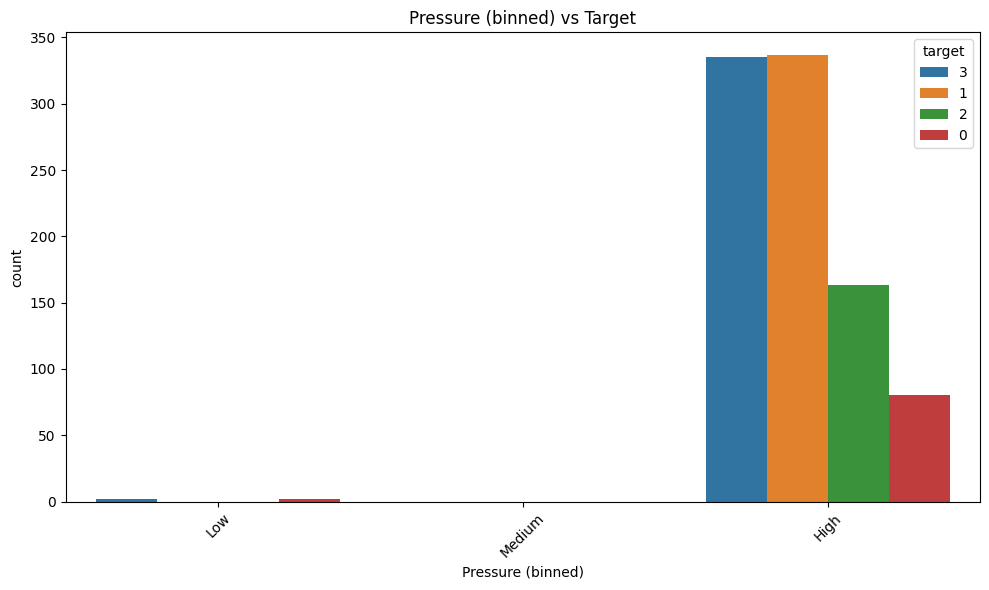

In [8]:
# Paso 8: Gráficos de variables pvs target 
# Convertir target a string para fines visuales
df_plot = X.copy()
df_plot['target'] = y.astype(str)

# Seleccionar variables discretizadas o categóricas generadas previamente
# Si ya tienes columnas discretizadas como en el paso 7D, puedes agregarlas aquí
df_plot['Wind Speed (binned)'] = pd.cut(X['Wind Speed (km/h)'], bins=3, labels=["Low", "Medium", "High"])
df_plot['Pressure (binned)'] = pd.cut(X['Pressure (millibars)'], bins=3, labels=["Low", "Medium", "High"])

categorical_columns = ['Wind Speed (binned)', 'Pressure (binned)']

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='target', data=df_plot)
    plt.title(f'{col} vs Target')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



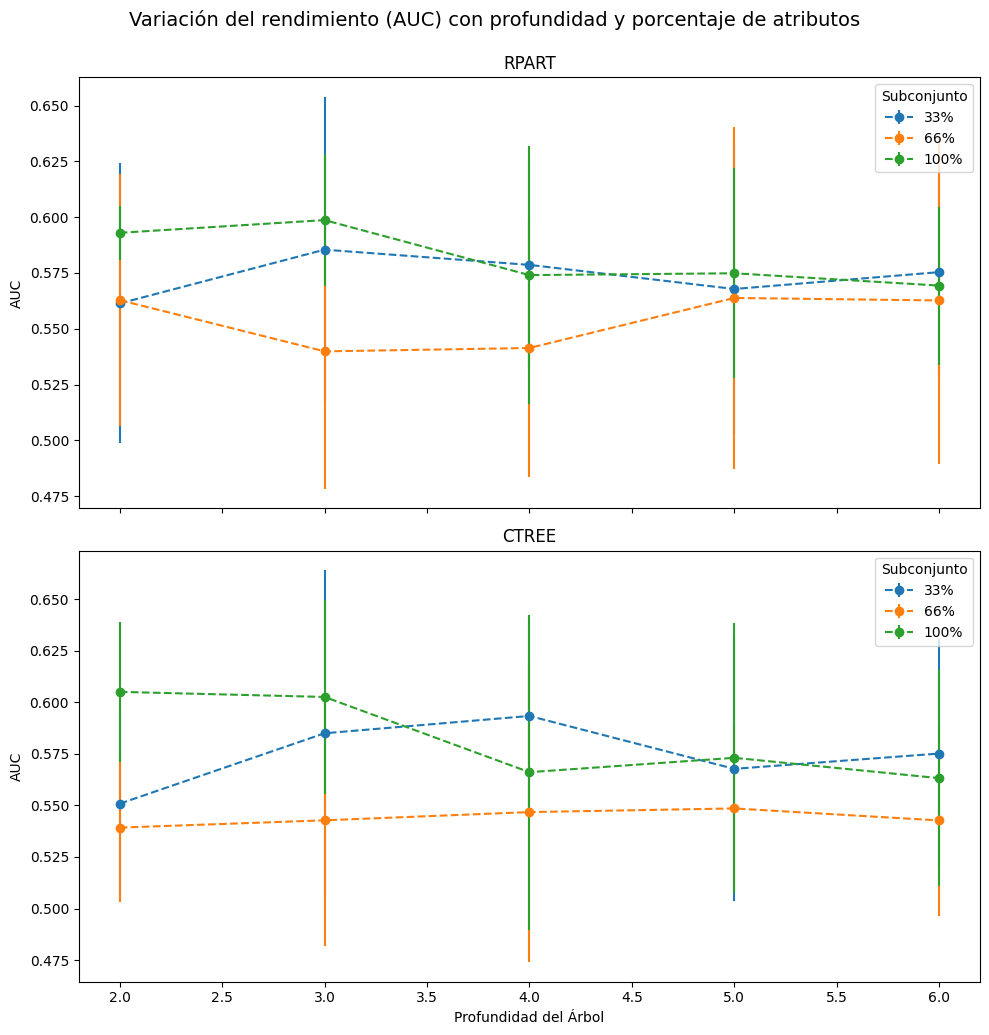

In [9]:
#paso 8.1: rendimiento (AUC) con profundidad y porcentaje de atributos
# Subconjuntos definidos
# Definición de subconjuntos de atributos
cols = X.columns.tolist()

subset_33 = cols[:max(1, len(cols)//3)]
subset_66 = cols[:max(1, 2*len(cols)//3)]
subset_100 = cols

attribute_sets = {
    '33%': subset_33,
    '66%': subset_66,
    '100%': subset_100
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, subset_cols in attribute_sets.items():
    X_subset = X[subset_cols]

    for depth in depths:
        # RPART (criterio Gini)
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X_subset, y, cv=5, scoring='roc_auc_ovr_weighted')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        # CTREE (criterio Entropía)
        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X_subset, y, cv=5, scoring='roc_auc_ovr_weighted')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

# Gráfica comparativa
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART")
axes[0].set_ylabel("AUC")
axes[0].legend(title="Subconjunto")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("CTREE")
axes[1].set_xlabel("Profundidad del Árbol")
axes[1].set_ylabel("AUC")
axes[1].legend(title="Subconjunto")

plt.tight_layout()
plt.suptitle("Variación del rendimiento (AUC) con profundidad y porcentaje de atributos", fontsize=14, y=1.03)
plt.show()


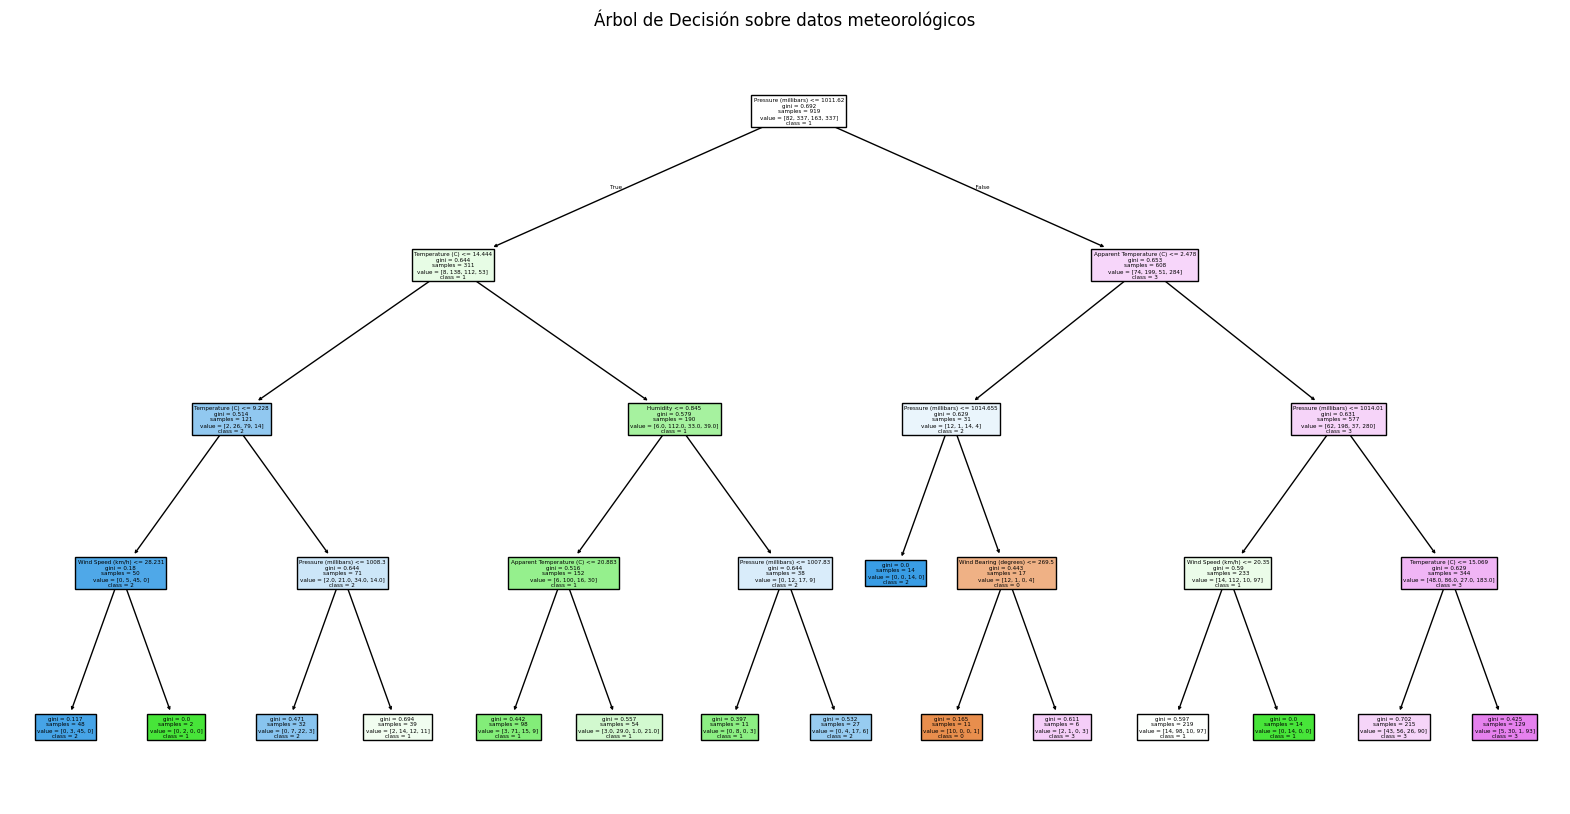

In [10]:
# Paso 9: Árbol de decisión
# Entrenar árbol con todos los datos
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X, y)

# Obtener nombres de clases reales
class_labels = y.astype('category').cat.categories.astype(str).tolist()

# Visualización del árbol
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=list(X.columns), class_names=class_labels)
plt.title("Árbol de Decisión sobre datos meteorológicos")
plt.show()


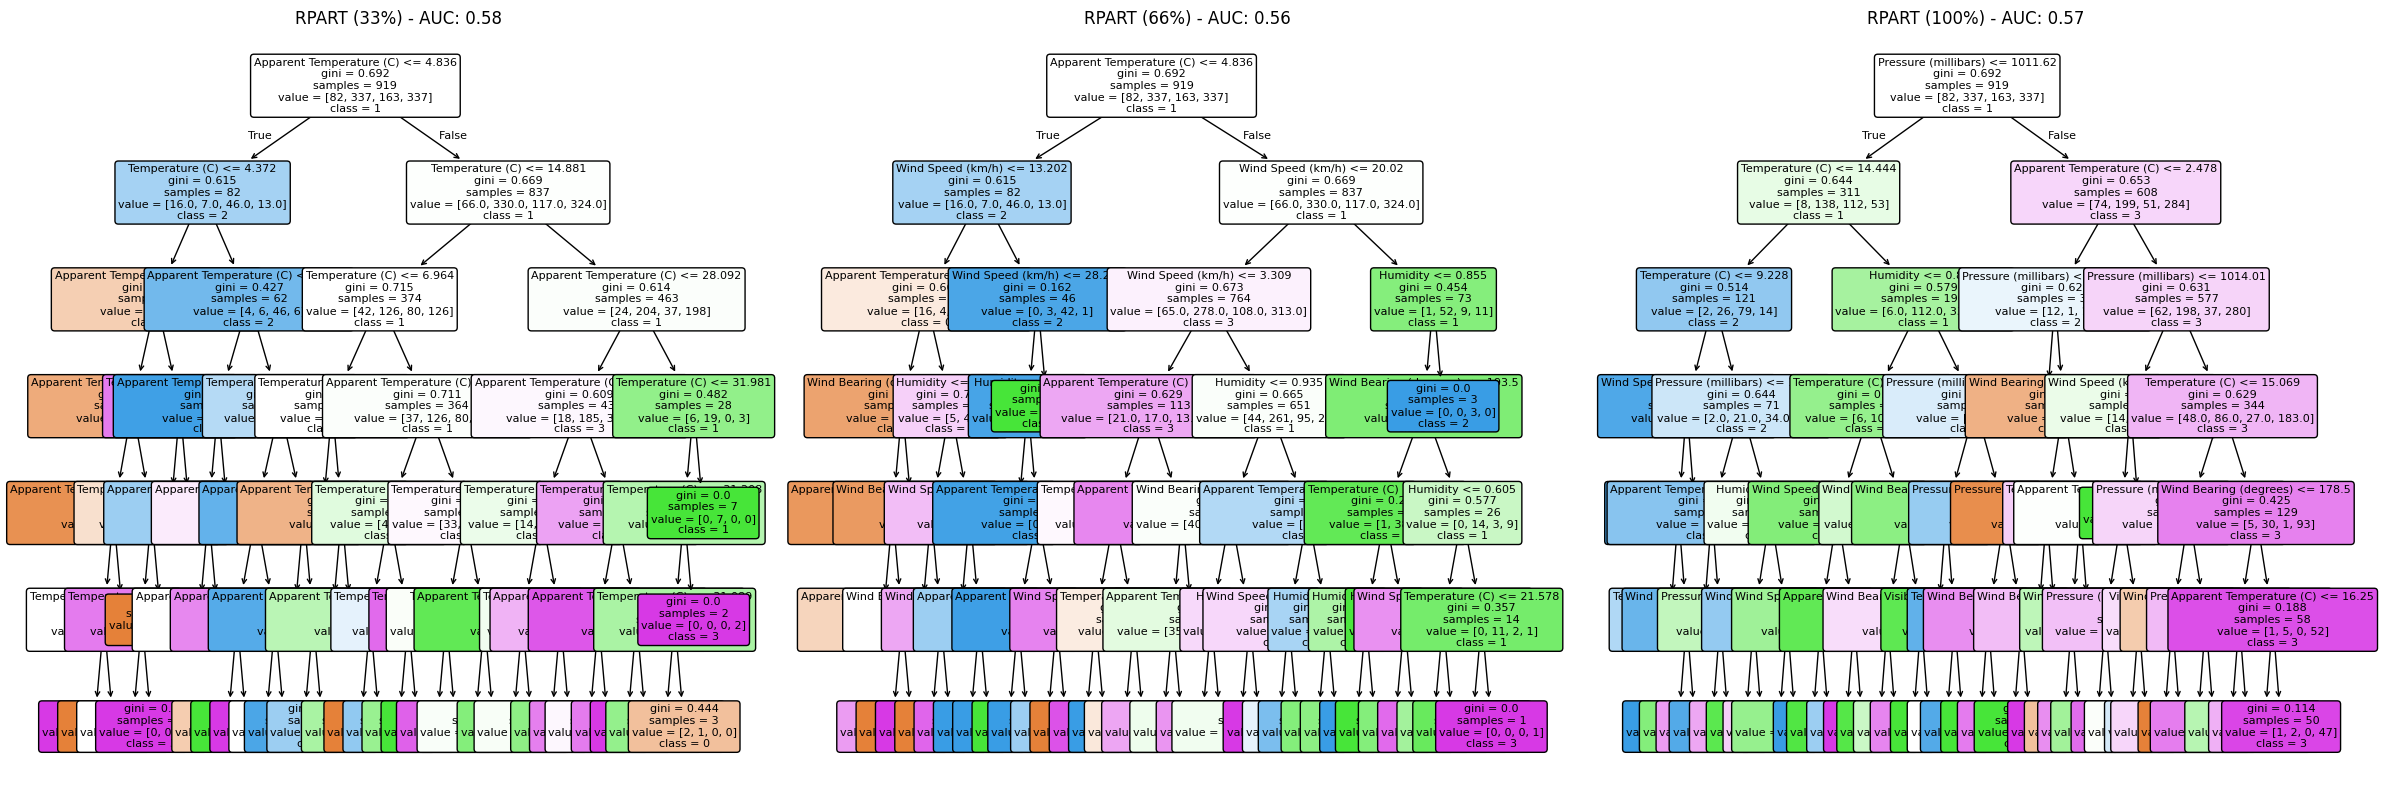

In [11]:
#Paso 9.1 Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)


from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

# Definir subconjuntos de atributos
df_vis_arbol = X.copy()
df_vis_arbol['target'] = y

subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
subset_100 = X.columns.tolist()

attribute_sets = {
    '33%': subset_33,
    '66%': subset_66,
    '100%': subset_100
}

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
rpart_auc_scores = {}

for ax, (name, subset_cols) in zip(axes, attribute_sets.items()):
    X_subset = X[subset_cols]
    y_subset = y

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X_subset, y_subset)

    auc = cross_val_score(model, X_subset, y_subset, cv=5, scoring='roc_auc_ovr_weighted').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X_subset.columns),
        class_names=y_subset.astype('category').cat.categories.astype(str).tolist(),
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.show()


In [12]:
from sklearn.tree import export_graphviz
import graphviz

# Preparar subconjunto 33% para visualización
subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
X_33 = X[subset_33]
y_33 = y

# Entrenar modelo
model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

# Exportar a formato DOT
dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=X_33.columns,
    class_names=y_33.astype('category').cat.categories.astype(str).tolist(),
    filled=True,
    rounded=True,
    special_characters=True
)

# Generar y exportar gráfico
graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)  # Exporta como PNG
graph_33.view()

'tree_33.pdf'

In [13]:
# 66%
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
X_66 = X[subset_66]
y_66 = y

# Entrenar modelo
model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)

# Exportar a formato DOT
dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=X_66.columns,
    class_names=y_66.astype('category').cat.categories.astype(str).tolist(),
    filled=True,
    rounded=True,
    special_characters=True
)

# Generar y exportar gráfico
graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)
graph_66.view()


'tree_66.pdf'

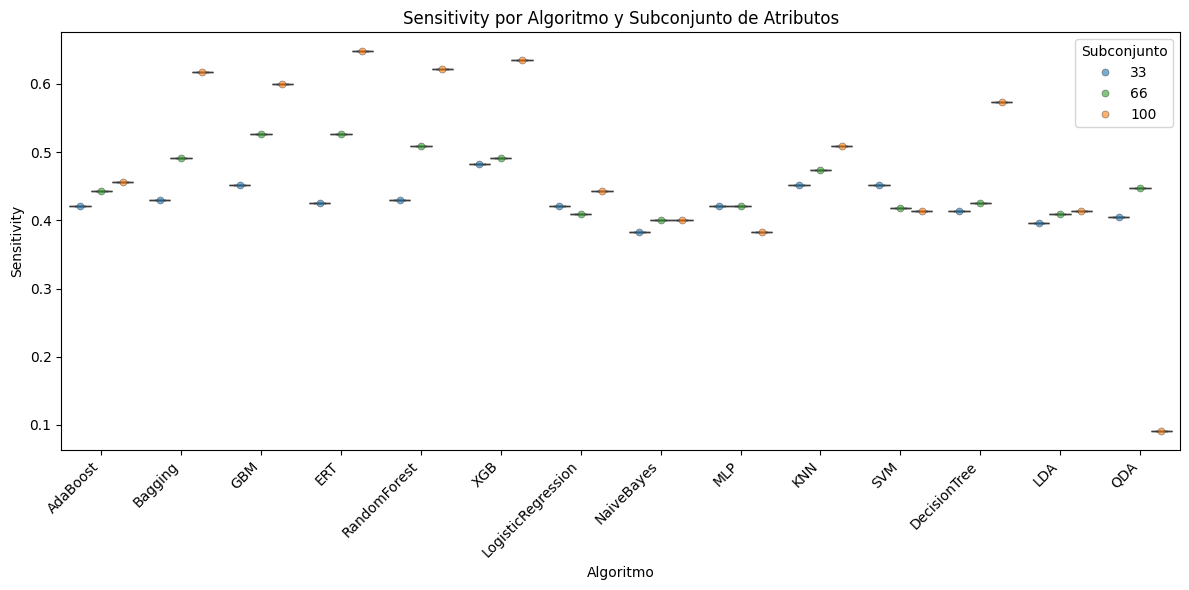

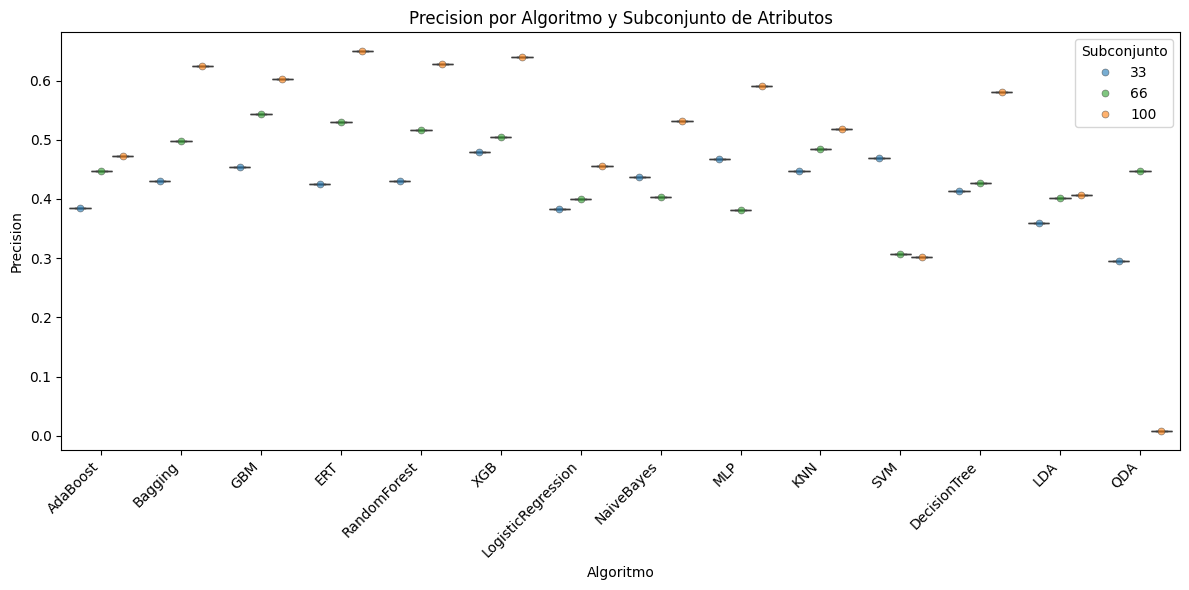

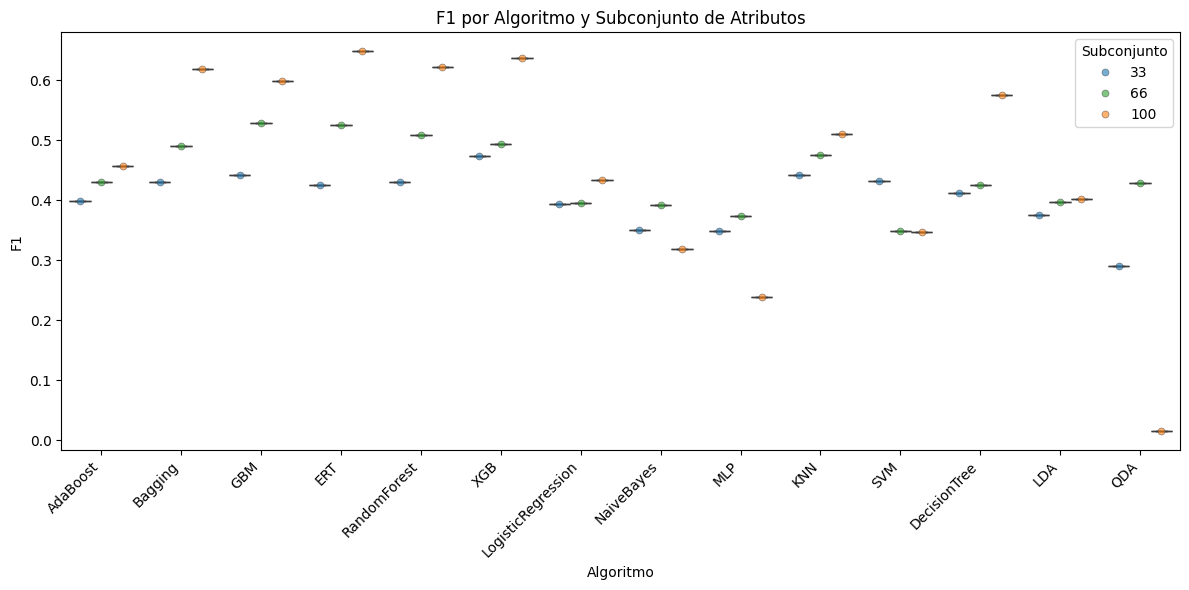

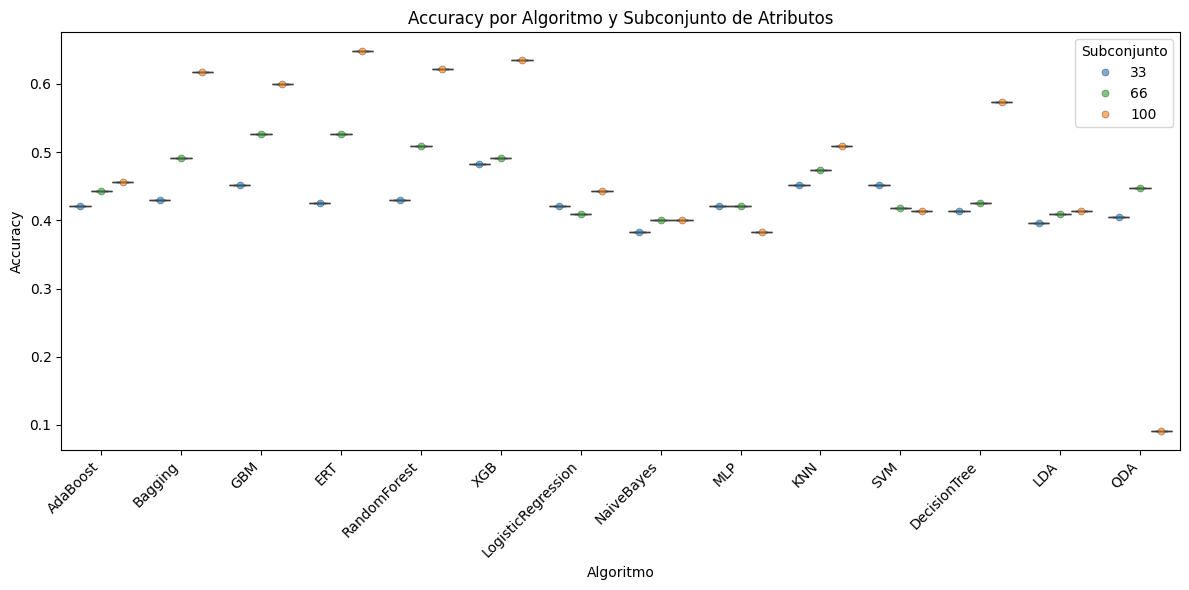

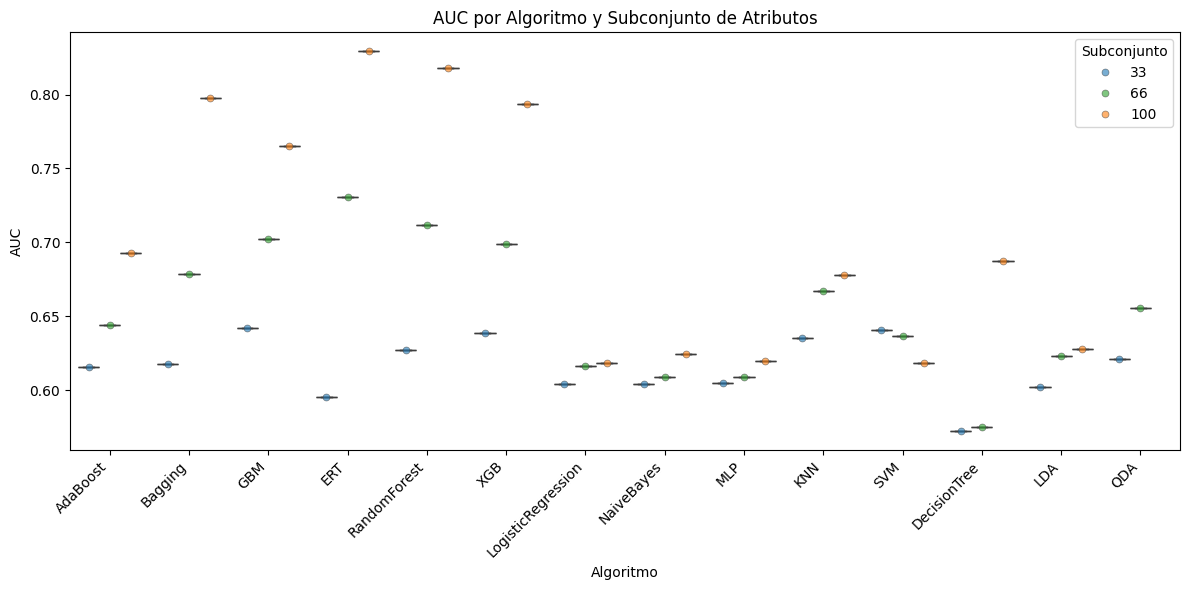

In [14]:
import matplotlib.patches as mpatches
# Paso 10: Evaluación con conjuntos de datos distintos
# Definir subconjuntos de atributos
subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
subset_100 = X.columns.tolist()

# Asignar colores a cada subconjunto
dataset_colors = {'33': '#1f77b4', '66': '#2ca02c', '100': '#ff7f0e'}

# Preparar datasets
df_vis_sets = X.copy()
df_vis_sets['target'] = y

datasets = {
    '33': df_vis_sets[subset_33 + ['target']],
    '66': df_vis_sets[subset_66 + ['target']],
    '100': df_vis_sets[subset_100 + ['target']]
}

results_all = []

for name, dataset in datasets.items():
    X_ds = dataset.drop('target', axis=1)
    y_ds = dataset['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X_ds, y_ds, test_size=0.25, random_state=42, stratify=y_ds)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        result['Algorithm'] = model_label
        results_all.append(result)

# Convertir a DataFrame
df_results_all = pd.DataFrame(results_all)
df_results_all['attr'] = df_results_all['attr'].astype(str)

# Visualización con colores por subconjunto (boxplots desplazados)

# NOTA:
# Si los boxplots aparecen en gris, es posible que se deba a una de estas causas:
# 1. El parámetro 'hue' no se está utilizando correctamente, o los valores en la columna correspondiente no coinciden con las claves definidas en 'palette'.
# 2. Los grupos no tienen suficiente dispersión (por ejemplo, un único valor por grupo), lo que hace que Seaborn pinte líneas en lugar de cajas, y estas aparecen en gris.
# 3. El estilo global de Seaborn (por ejemplo, sns.set_theme()) puede estar sobreescribiendo los colores definidos en la paleta.

# Solución: superponer stripplot para garantizar la visualización de los colores.
for metric in ['Sensitivity', 'Precision', 'F1', 'Accuracy', 'AUC']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='Algorithm',
        y=metric,
        hue='attr',
        data=df_results_all,
        palette=dataset_colors,
        dodge=True
    )
    sns.stripplot(
        x='Algorithm',
        y=metric,
        hue='attr',
        data=df_results_all,
        palette=dataset_colors,
        dodge=True,
        linewidth=0.5,
        edgecolor='gray',
        marker='o',
        alpha=0.6
    )
    plt.title(f'{metric} por Algoritmo y Subconjunto de Atributos')
    plt.xlabel("Algoritmo")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')

    # Eliminar duplicados en la leyenda
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Subconjunto', loc='upper right')
    plt.tight_layout()
    plt.show()




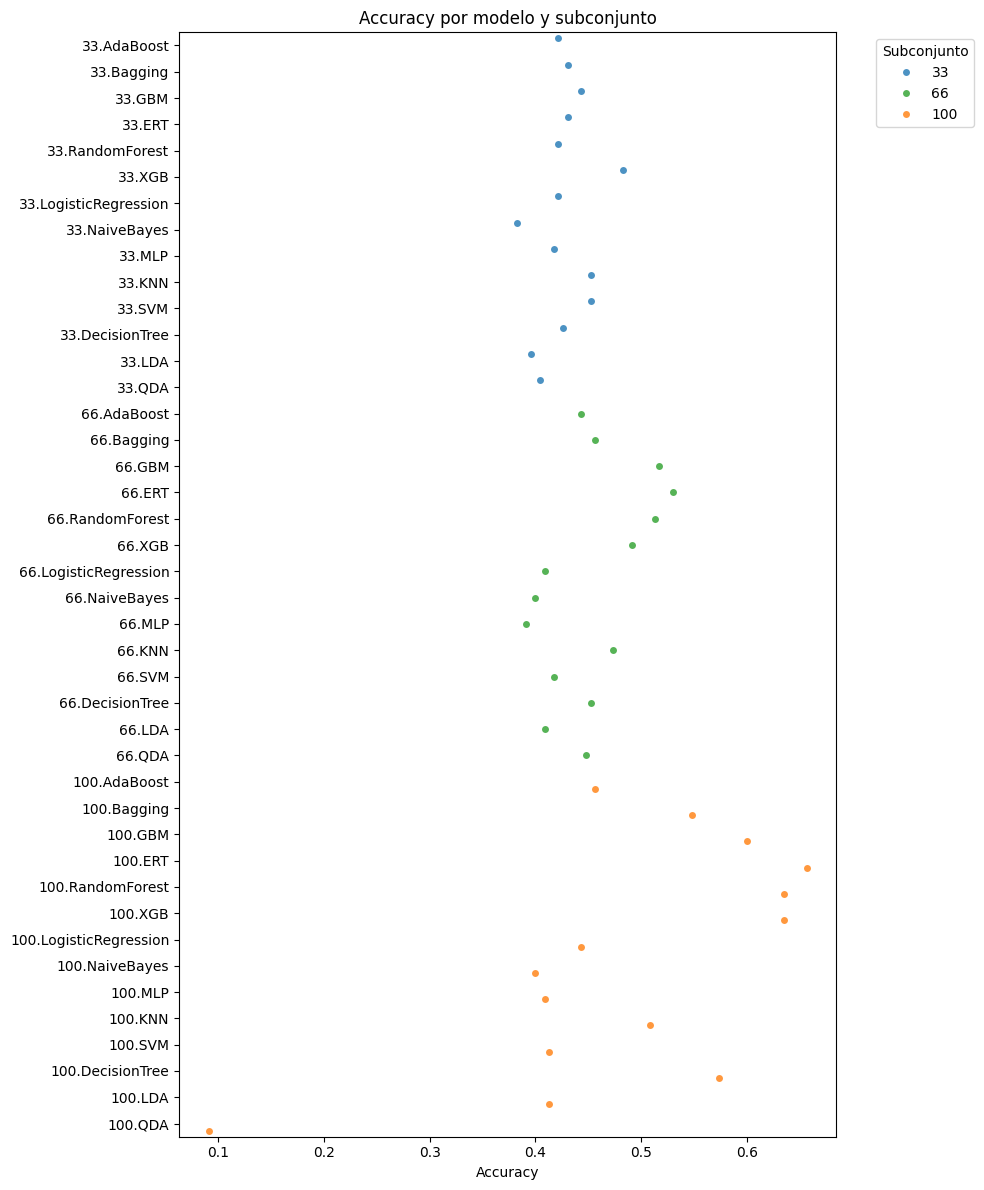

In [15]:
import matplotlib.gridspec as gridspec
# Paso 10.1: Evaluación con conjuntos de datos distintos y visualización de Accuracy tipo boxplot

import matplotlib.gridspec as gridspec

# Preparar subconjuntos de atributos desde X
df_vis = X.copy()
df_vis['target'] = y

subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
subset_100 = X.columns.tolist()

datasets = {
    '33': df_vis[subset_33 + ['target']],
    '66': df_vis[subset_66 + ['target']],
    '100': df_vis[subset_100 + ['target']]
}

results_all = []

for name, dataset in datasets.items():
    X_ds = dataset.drop('target', axis=1)
    y_ds = dataset['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X_ds, y_ds, test_size=0.25, random_state=42, stratify=y_ds)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        result['Algorithm'] = model_label
        results_all.append(result)

# Crear DataFrame consolidado
df_results_all = pd.DataFrame(results_all)
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Crear gráfico alternativo usando stripplot para asegurar visualización correcta

plt.figure(figsize=(10, 12))
sns.stripplot(
    data=df_results_all,
    y='Label',
    x='Accuracy',
    hue='attr',
    palette={'33': '#1f77b4', '66': '#2ca02c', '100': '#ff7f0e'},
    dodge=True,
    alpha=0.8
)
plt.title("Accuracy por modelo y subconjunto")
plt.xlabel("Accuracy")
plt.ylabel("")
plt.legend(title='Subconjunto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




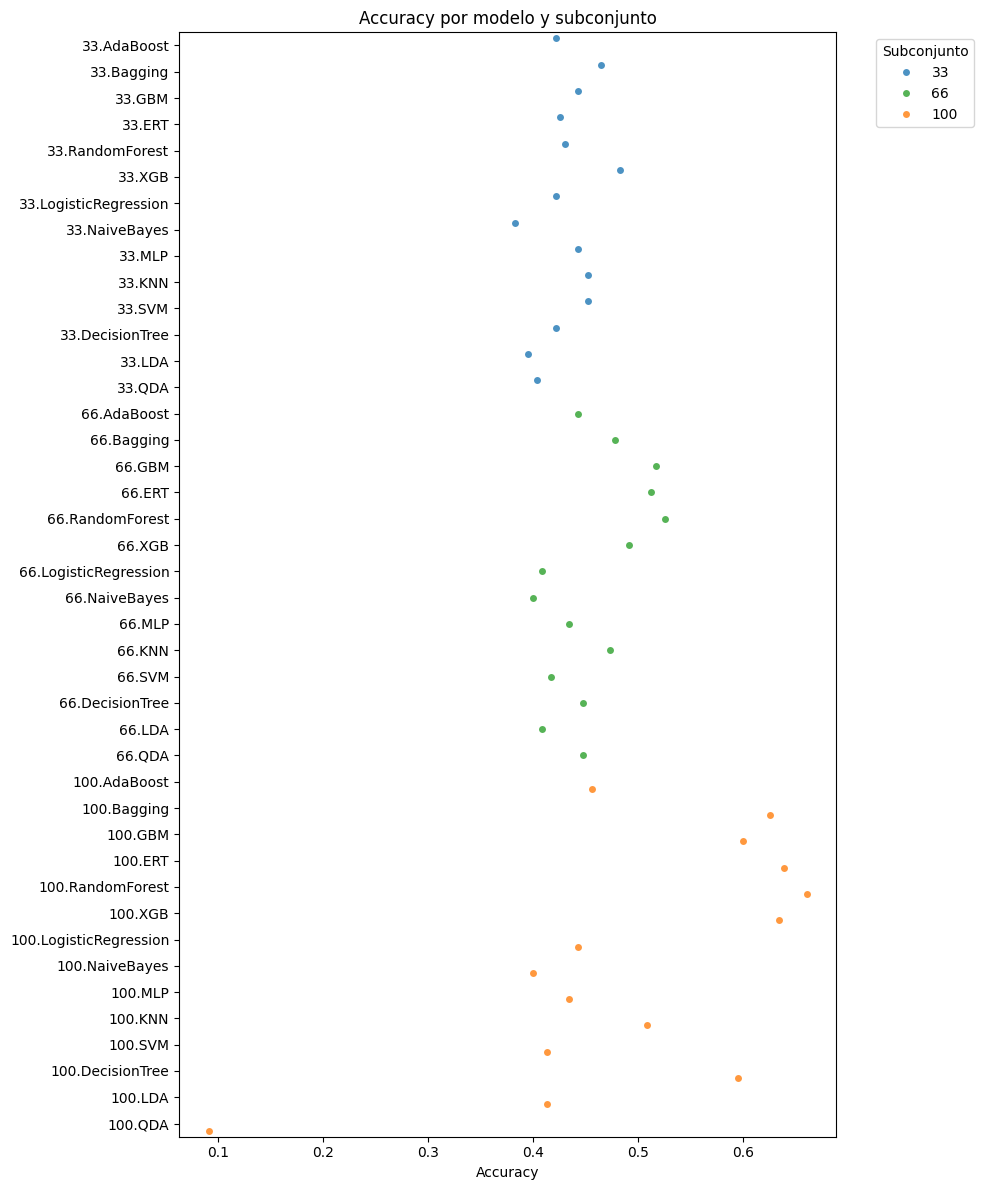

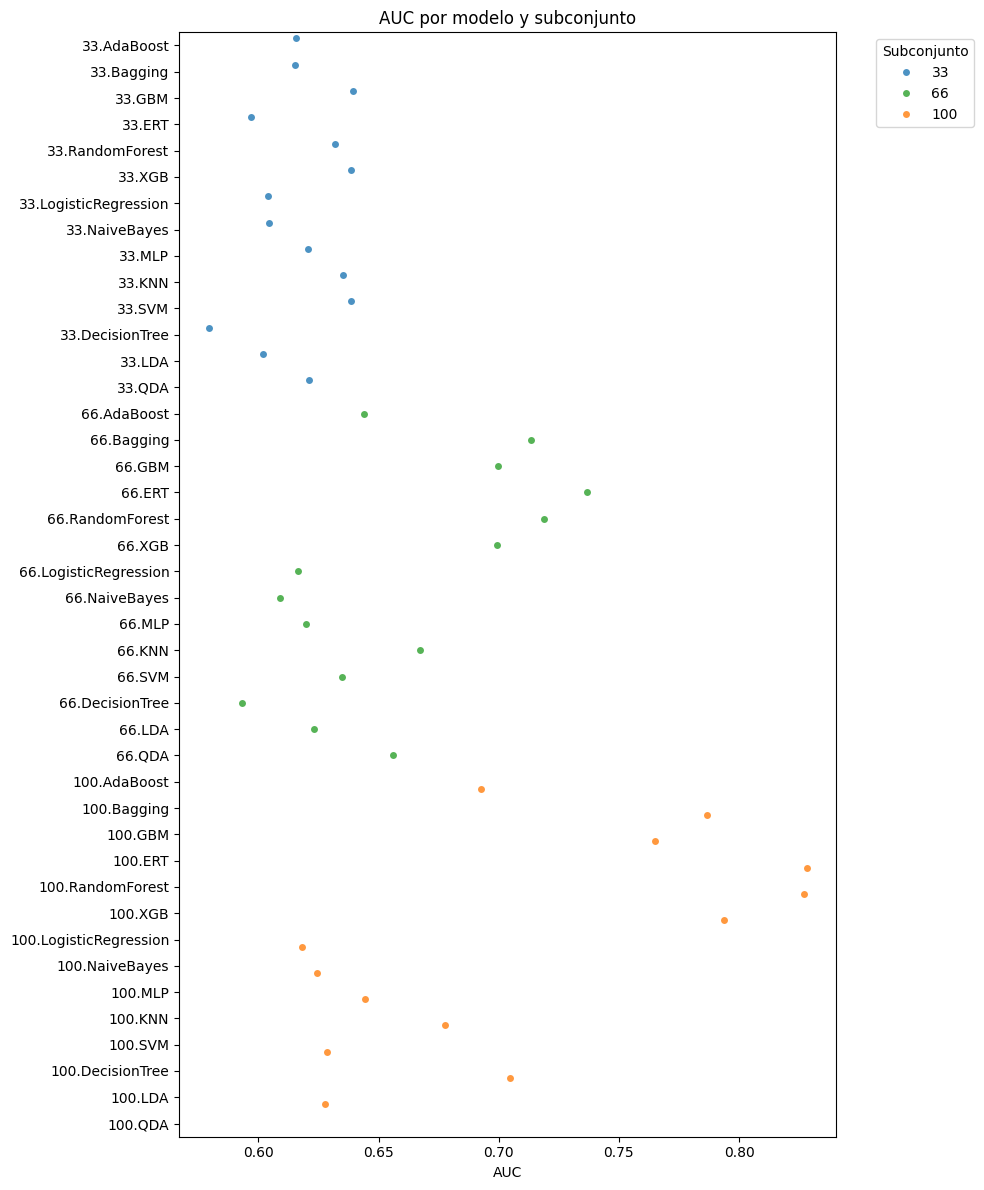

In [16]:
# Gráfico tipo panel para AUC tipo boxplot de los diferentes conjuntos de datos 
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de que estas columnas estén generadas
df_vis = X.copy()
df_vis['target'] = y

subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
subset_100 = X.columns.tolist()

datasets = {
    '33': df_vis[subset_33 + ['target']],
    '66': df_vis[subset_66 + ['target']],
    '100': df_vis[subset_100 + ['target']]
}

results_all = []

for name, dataset in datasets.items():
    X_ds = dataset.drop('target', axis=1)
    y_ds = dataset['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X_ds, y_ds, test_size=0.25, random_state=42, stratify=y_ds)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        result['Algorithm'] = model_label
        results_all.append(result)

# Crear DataFrame consolidado
df_results_all = pd.DataFrame(results_all)
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Crear gráfico alternativo usando stripplot para asegurar visualización correcta

plt.figure(figsize=(10, 12))
sns.stripplot(
    data=df_results_all,
    y='Label',
    x='Accuracy',
    hue='attr',
    palette={'33': '#1f77b4', '66': '#2ca02c', '100': '#ff7f0e'},
    dodge=True,
    alpha=0.8
)
plt.title("Accuracy por modelo y subconjunto")
plt.xlabel("Accuracy")
plt.ylabel("")
plt.legend(title='Subconjunto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico tipo panel para AUC por modelo y subconjunto (usando stripplot)
metric = 'AUC'
sorted_labels_auc = df_results_all.groupby('Label')[metric].mean().sort_values().index

plt.figure(figsize=(10, 12))
sns.stripplot(
    data=df_results_all[df_results_all['Label'].isin(sorted_labels_auc)],
    y='Label',
    x=metric,
    hue='attr',
    palette={'33': '#1f77b4', '66': '#2ca02c', '100': '#ff7f0e'},
    dodge=True,
    alpha=0.8
)
plt.title("AUC por modelo y subconjunto")
plt.xlabel("AUC")
plt.ylabel("")
plt.legend(title='Subconjunto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
# Análisis de Curvas de Rashomon con Múltiples Conjuntos de Atributos

import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd

warnings.filterwarnings('ignore')

# Supuestos: variables disponibles
# X, y, ranking_df, models

# Definición de subconjuntos de atributos
total_features = len(ranking_df)
feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(round(0.33 * total_features)).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(round(0.66 * total_features)).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)
                if y_prob.shape[1] > 1:
                    from sklearn.preprocessing import label_binarize
                    y_bin = label_binarize(y_valid_r, classes=list(range(y_prob.shape[1])))
                    auc = roc_auc_score(y_bin, y_prob, average='macro')
                else:
                    auc = roc_auc_score(y_valid_r, y_prob[:, 0])
            except:
                auc = roc_auc_score(y_valid_r, y_pred)

            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            elif hasattr(model, 'estimators_'):
                complexity = sum([est.tree_.node_count for est in model.estimators_])
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)
rashomon_df

Error with QDA on top100: multi_class must be in ('ovo', 'ovr')


,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon
0,top33,AdaBoost,0.766009,0.117300,50.000000,0.793773,3,False
1,top33,Bagging,0.783995,0.042460,10.000000,0.793773,3,True
2,top33,GBM,0.792155,0.792865,100.000000,0.793773,3,True
3,top33,ERT,0.772234,0.194764,100.000000,0.793773,3,False
4,top33,RandomForest,0.793773,0.218258,100.000000,0.793773,3,True
5,top33,XGB,0.782725,0.163042,NaN,0.793773,3,False
6,top33,LogisticRegression,0.655467,0.370739,3.000000,0.793773,3,False
7,top33,NaiveBayes,0.667258,0.000000,0.000000,0.793773,3,False
8,top33,MLP,0.621292,0.160443,100.000000,0.793773,3,False
9,top33,KNN,0.780397,0.000000,0.000000,0.793773,3,False


In [18]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)

def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")
pareto_df[pareto_df['ParetoFront']]

Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon,ParetoFront
1,top33,Bagging,0.783995,0.042460,10.000000,0.793773,3,True,True
4,top33,RandomForest,0.793773,0.218258,100.000000,0.793773,3,True,True
5,top33,XGB,0.782725,0.163042,NaN,0.793773,3,False,True
9,top33,KNN,0.780397,0.000000,0.000000,0.793773,3,False,True
15,top66,Bagging,0.816866,0.048420,10.000000,0.847086,2,False,True
17,top66,ERT,0.847086,0.160603,100.000000,0.847086,2,True,True
19,top66,XGB,0.832979,0.192445,NaN,0.847086,2,False,True
21,top66,NaiveBayes,0.706915,0.000000,0.000000,0.847086,2,False,True
27,top66,QDA,0.710007,0.003042,0.003042,0.847086,2,False,True
29,top100,Bagging,0.839105,0.056963,10.000000,0.873072,2,False,True


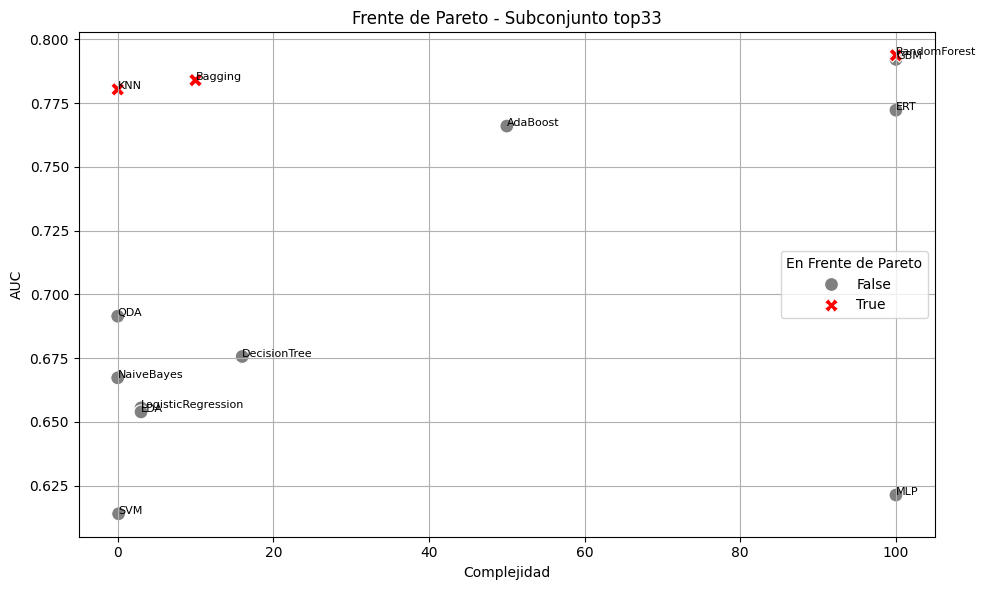

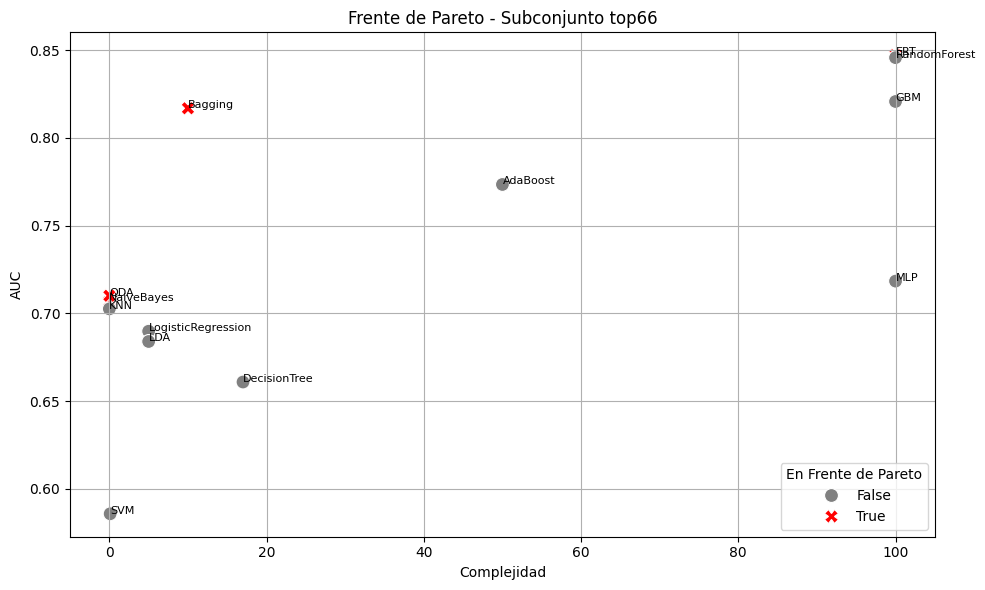

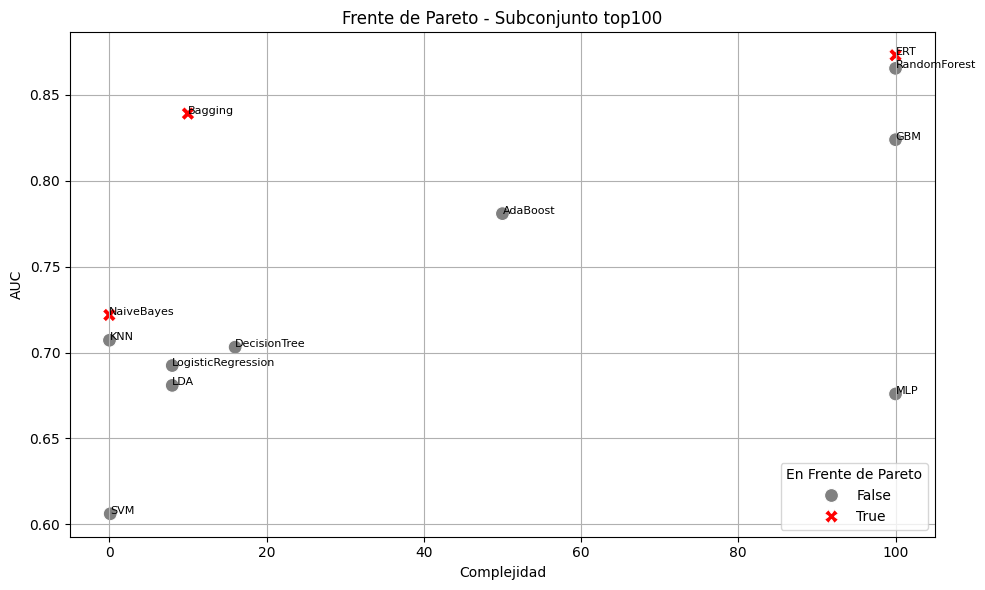

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()